# Lecture 15: Class demo

Let's cluster images!!

For this demo, I'm going to use the following image dataset: 
1. A tiny subset of [Food-101](https://www.kaggle.com/datasets/kmader/food41?select=food_c101_n10099_r32x32x1.h5) from last lecture
(available [here](https://github.ubc.ca/mds-2021-22/datasets/blob/master/data/food.zip)).
2. A small subset of [Human Faces dataset](https://www.kaggle.com/datasets/ashwingupta3012/human-faces) (available [here](https://ubcca-my.sharepoint.com/:u:/g/personal/varada_kolhatkar_ubc_ca/EYDqm7QJLfdGh1A0dyqh76kB6PH9ohca-lVrJGATrEh3CQ?e=msqcPM)).

To run the code below, you need to install pytorch and torchvision in the course conda environment. 

```conda install pytorch torchvision -c pytorch```

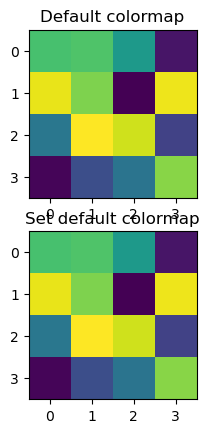

In [1]:
import os, sys
sys.path.append(os.path.join(os.path.abspath(".."), "code"))
from plotting_functions_unsup import *

In [2]:
import random
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, models, transforms, utils
from PIL import Image
from torchvision import transforms
from torchvision.models import vgg16
import matplotlib.pyplot as plt

In [3]:
import torchvision

Let's start with  small subset of birds dataset. You can experiment with a bigger dataset if you like.

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [6]:
set_seed(seed=42)

In [7]:
import glob
IMAGE_SIZE = 200
def read_img_dataset(data_dir):     
    data_transforms = transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),     
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),            
        ])
               
    image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
    dataloader = torch.utils.data.DataLoader(
         image_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
    )
    dataset_size = len(image_dataset)
    class_names = image_dataset.classes
    inputs, classes = next(iter(dataloader))
    return inputs, classes

In [8]:
def plot_sample_imgs(inputs):
    plt.figure(figsize=(10, 70)); plt.axis("off"); plt.title("Sample Training Images")
    plt.imshow(np.transpose(utils.make_grid(inputs, padding=1, normalize=True),(1, 2, 0)));

In [9]:
def get_features(model, inputs):
    """Extract output of densenet model"""
    with torch.no_grad():  # turn off computational graph stuff
        Z_train = torch.empty((0, 1024))  # Initialize empty tensors
        y_train = torch.empty((0))
        Z_train = torch.cat((Z_train, model(inputs)), dim=0)
    return Z_train.detach()

In [10]:
densenet = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")
densenet.classifier = torch.nn.Identity()  # remove that last "classification" layer

In [11]:
data_dir = "../data/food"
file_names = [image_file for image_file in glob.glob(data_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
food_inputs, food_classes = read_img_dataset(data_dir)
n_images

350

In [12]:
X_food = food_inputs.numpy()

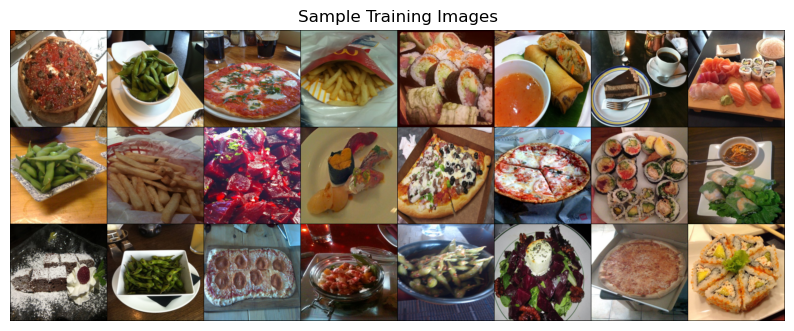

In [13]:
plot_sample_imgs(food_inputs[0:24,:,:,:])

In [14]:
Z_food = get_features(
    densenet, food_inputs, 
)

In [15]:
Z_food = Z_food.numpy()

In [16]:
Z_food.shape

(350, 1024)

In [17]:
from sklearn.cluster import KMeans

k = 7
km = KMeans(n_clusters=k, n_init='auto', random_state=123)
km.fit(Z_food)

KMeans(n_clusters=7, n_init='auto', random_state=123)

Image indices:  [ 82  58 168 114 122  44]


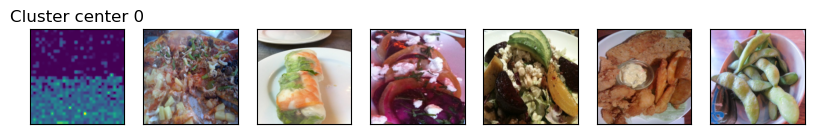

Image indices:  [ 89 209  67 330 141 166]


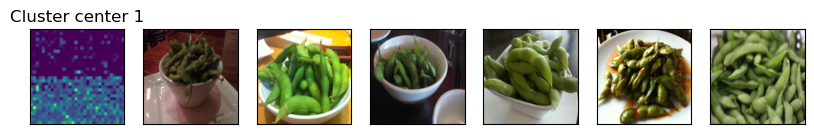

Image indices:  [249 327 331  30 236 267]


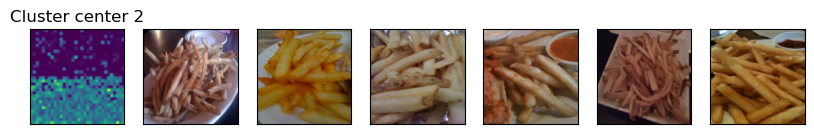

Image indices:  [ 76  90  29 240 237 238]


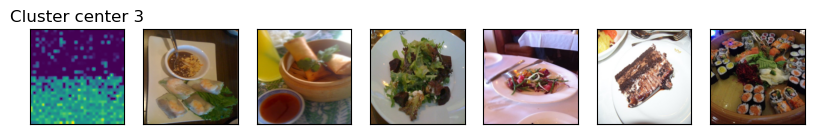

Image indices:  [223 136 124 304  13 137]


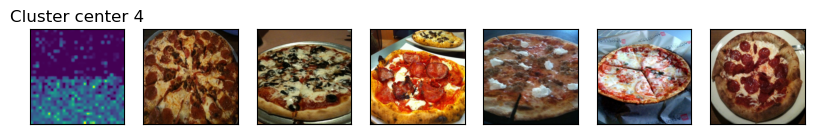

Image indices:  [190 132  73 140   6 149]


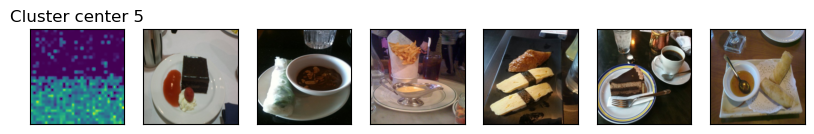

Image indices:  [ 65 238 237 236 235 234]


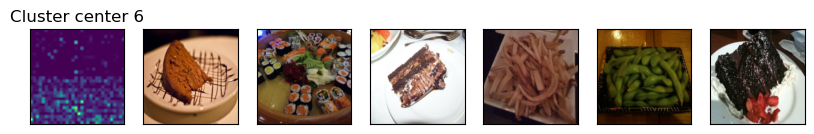

In [18]:
for cluster in range(k):
    get_cluster_images(km, Z_food, X_food, cluster, n_img=6)

Let's try DBSCAN.

In [19]:
dbscan = DBSCAN()

labels = dbscan.fit_predict(Z_food)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


It identified all points as noise points. Let's explore the distances between points. 

In [20]:
from sklearn.metrics.pairwise import euclidean_distances

dists = euclidean_distances(Z_food)
np.fill_diagonal(dists, np.inf)
dists_df = pd.DataFrame(dists)
dists_df

0          1          2          3          4          5    \
0          inf  27.838209  24.272423  28.557386  25.911512  26.729088   
1    27.838209        inf  25.690664  26.808674  28.380119  26.499969   
2    24.272423  25.690664        inf  26.241850  26.272598  24.983030   
3    28.557386  26.808674  26.241850        inf  28.488819  26.426289   
4    25.911512  28.380119  26.272598  28.488819        inf  25.054052   
..         ...        ...        ...        ...        ...        ...   
345  28.312830  27.344963  25.965456  24.505461  26.731318  27.732960   
346  30.730888  26.383554  29.195887  29.599627  29.328199  27.754042   
347  26.483530  24.948429  25.397800  27.887571  26.524778  25.069878   
348  26.518341  23.117655  23.607014  26.735687  26.566645  23.524864   
349  27.012949  25.012907  23.029932  26.722355  26.233059  25.000036   

           6          7          8          9    ...        340        341  \
0    28.535007  27.919943  29.910038  24.831701  ...  25.821581  27.069433   
1    25.269186  27.080601  24.174231  26.724173  ...  25.517481  22.425566   
2    25.745886  26.138418  27.259501  23.387449  ...  24.976543  24.755798   
3    28.817778  29.362293  27.543203  22.214371  ...  24.433807  26.525894   
4    28.763035  28.249685  29.294979  24.665562  ...  25.088818  26.409763   
..         ...        ...        ...        ...  ...        ...        ...   
345  28.961937  28.021688  28.355204  24.388792  ...  23.226387  25.771818   
346  30.597506  31.449287  29.049765  26.228279  ...  26.203318  26.634016   
347  26.720396  27.640726  28.087231  24.709068  ...  24.990519  25.950739   
348  23.816399  25.144579  25.315739  25.252844  ...  25.219345  23.628778   
349  24.752766  26.942122  27.648315  25.040714  ...  24.330954  25.934887   

           342        343        344        345        346        347  \
0    27.836058  27.045502  28.334972  28.312830  30.730888  26.483530   
1    24.153849  26.348946  28.451920  27.344963  26.383554  24.948429   
2    26.489601  26.757547  23.980059  25.965456  29.195887  25.397800   
3    26.772890  28.805965  26.740297  24.505461  29.599627  27.887571   
4    27.046513  26.512915  28.122980  26.731318  29.328199  26.524778   
..         ...        ...        ...        ...        ...        ...   
345  26.816877  29.633665  27.816105        inf  29.698130  26.911955   
346  25.843769  28.824900  31.539536  29.698130        inf  28.891027   
347  26.422796  23.982191  27.307524  26.911955  28.891027        inf   
348  24.586554  24.797318  25.021420  25.400141  29.559868  24.929638   
349  26.133183  24.376286  26.258141  26.690134  28.736403  22.822123   

           348        349  
0    26.518341  27.012949  
1    23.117655  25.012907  
2    23.607014  23.029932  
3    26.735687  26.722355  
4    26.566645  26.233059  
..         ...        ...  
345  25.400141  26.690134  
346  29.559868  28.736403  
347  24.929638  22.822123  
348        inf  24.156252  
349  24.156252        inf  

[350 rows x 350 columns]

In [21]:
dists.min(), np.nanmax(dists[dists != np.inf]), np.mean(dists[dists != np.inf])

(14.918853, 39.791836, 27.870182)

In [22]:
for eps in range(16, 30):
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(Z_food)
    print("Number of clusters: {}".format(len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=16
Number of clusters: 1
Cluster sizes: [350]

eps=17
Number of clusters: 3
Cluster sizes: [341   5   4]

eps=18
Number of clusters: 3
Cluster sizes: [334  13   3]

eps=19
Number of clusters: 3
Cluster sizes: [311  35   4]

eps=20
Number of clusters: 4
Cluster sizes: [274  70   3   3]

eps=21
Number of clusters: 2
Cluster sizes: [234 116]

eps=22
Number of clusters: 2
Cluster sizes: [182 168]

eps=23
Number of clusters: 2
Cluster sizes: [132 218]

eps=24
Number of clusters: 2
Cluster sizes: [ 81 269]

eps=25
Number of clusters: 2
Cluster sizes: [ 52 298]

eps=26
Number of clusters: 2
Cluster sizes: [ 30 320]

eps=27
Number of clusters: 2
Cluster sizes: [ 17 333]

eps=28
Number of clusters: 2
Cluster sizes: [  5 345]

eps=29
Number of clusters: 2
Cluster sizes: [  2 348]


In [23]:
dbscan = DBSCAN(eps=18, min_samples=3)
dbscan_labels = dbscan.fit_predict(Z_food)
print("Number of clusters: {}".format(len(np.unique(dbscan_labels))))
print("Cluster sizes: {}".format(np.bincount(dbscan_labels + 1)))
print("Unique labels: {}".format(np.unique(dbscan_labels)))

Number of clusters: 3
Cluster sizes: [334  13   3]
Unique labels: [-1  0  1]


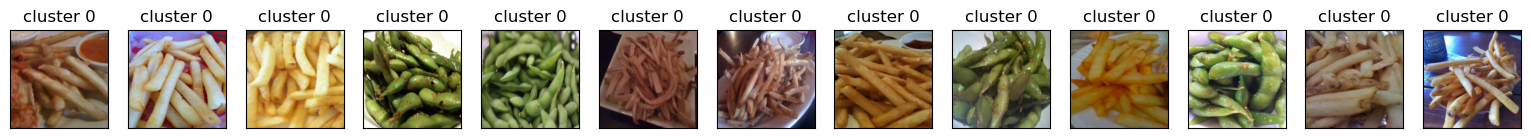

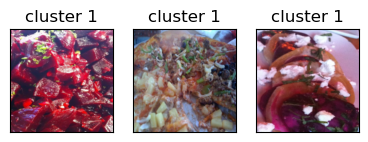

In [24]:
print_dbscan_clusters(Z_food, food_inputs, dbscan_labels)

Let's examine noise points identified by DBSCAN. 

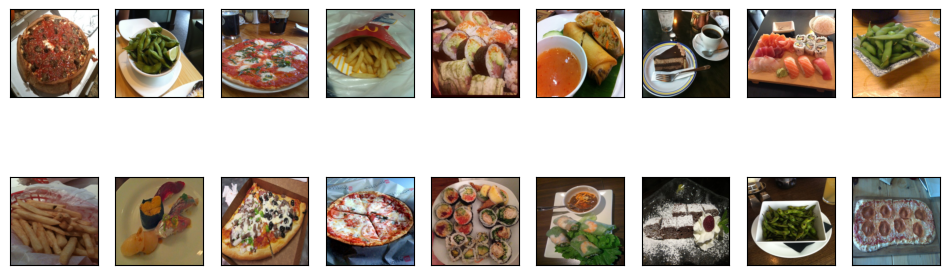

In [25]:
print_dbscan_noise_images(Z_food, food_inputs, dbscan_labels)

<br><br>

Now let's try another dataset with human faces, a small subset of [Human Faces dataset](https://www.kaggle.com/datasets/ashwingupta3012/human-faces) (available [here](https://ubcca-my.sharepoint.com/:u:/g/personal/varada_kolhatkar_ubc_ca/EYDqm7QJLfdGh1A0dyqh76kB6PH9ohca-lVrJGATrEh3CQ?e=msqcPM)).

In [27]:
data_dir = "../data/test"
file_names = [image_file for image_file in glob.glob(data_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
faces_inputs, classes = read_img_dataset(data_dir)

In [28]:
X_faces = faces_inputs.numpy()
X_faces.shape

(367, 3, 200, 200)

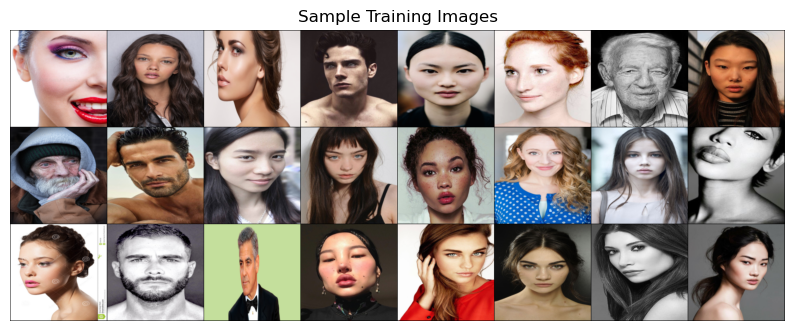

In [29]:
plot_sample_imgs(faces_inputs[0:24,:,:,:])

In [30]:
Z_faces = get_features(
    densenet, faces_inputs, 
).numpy()

In [31]:
Z_faces.shape

(367, 1024)

In [32]:
from sklearn.cluster import KMeans

k = 7
km = KMeans(n_clusters=k, n_init='auto', random_state=123)
km.fit(Z_faces)

KMeans(n_clusters=7, n_init='auto', random_state=123)

In [33]:
km.cluster_centers_.shape

(7, 1024)

Image indices:  [136 175 355 285  56 346]


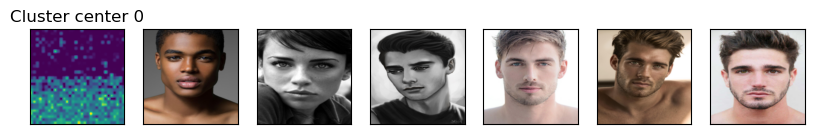

Image indices:  [117 320 208 216 186  59]


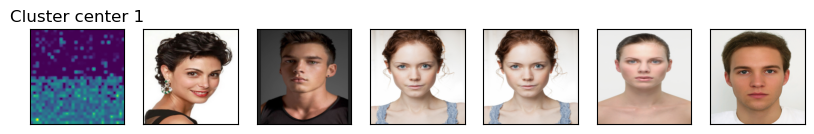

Image indices:  [103 353 359 295  68  60]


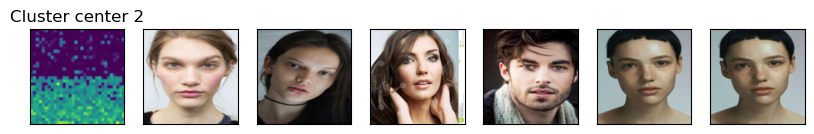

Image indices:  [ 39 357 332 256 218   1]


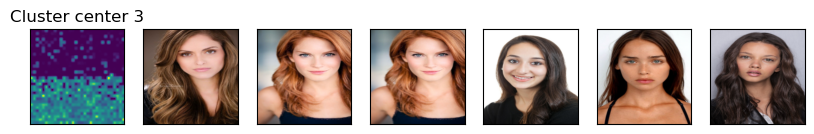

Image indices:  [317 168 267   0 248 247]


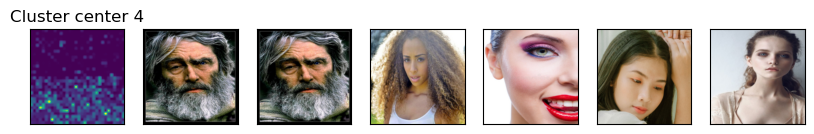

Image indices:  [290 124 271  83 139 146]


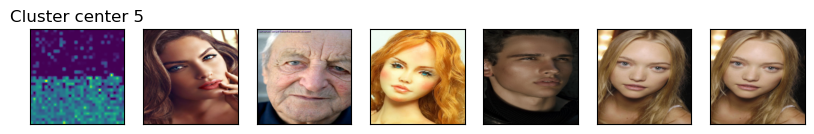

Image indices:  [312 260 329 127  40 348]


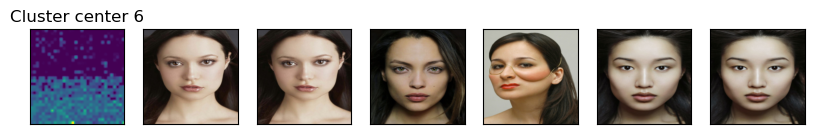

In [34]:
for cluster in range(k):
    get_cluster_images(km, Z_faces, X_faces, cluster, n_img=6)

<br><br>

### Clustering faces with DBSCAN

In [35]:
dbscan = DBSCAN()
labels = dbscan.fit_predict(Z_faces)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


In [36]:
dists = euclidean_distances(Z_faces)
np.fill_diagonal(dists, np.inf)

dist_df = pd.DataFrame(
    dists
)

dist_df.iloc[10:20, 10:20]

10         11         12         13         14         15  \
10        inf  22.212444  29.023613  24.863905  22.001663  24.938940   
11  22.212444        inf  27.826571  22.514793  19.561979  26.348663   
12  29.023613  27.826571        inf  27.719786  28.463976  27.759411   
13  24.863905  22.514793  27.719786        inf  22.240793  24.963823   
14  22.001663  19.561979  28.463976  22.240793        inf  25.906570   
15  24.938940  26.348663  27.759411  24.963823  25.906570        inf   
16  28.098724  26.740641  26.995085  25.705948  27.872011  27.595673   
17  30.955692  31.028826  29.543497  29.509878  29.647667  26.784702   
18  27.270945  27.770222  29.854399  27.242216  28.404259  28.887432   
19  27.389570  27.892704  25.650290  26.694988  27.862476  25.958988   

           16         17         18         19  
10  28.098724  30.955692  27.270945  27.389570  
11  26.740641  31.028826  27.770222  27.892704  
12  26.995085  29.543497  29.854399  25.650290  
13  25.705948  29.509878  27.242216  26.694988  
14  27.872011  29.647667  28.404259  27.862476  
15  27.595673  26.784702  28.887432  25.958988  
16        inf  29.354176  28.925968  26.882242  
17  29.354176        inf  33.242348  29.911688  
18  28.925968  33.242348        inf  29.257753  
19  26.882242  29.911688  29.257753        inf

In [37]:
dists.min(), np.nanmax(dists[dists != np.inf]), np.mean(dists[dists != np.inf])

(0.0, 36.27959, 25.94334)

In [38]:
for eps in [16, 17, 18, 19, 20, 21, 22, 24]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(Z_faces)
    print("Number of clusters: {}".format(len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=16
Number of clusters: 8
Cluster sizes: [345   3   3   3   3   4   3   3]

eps=17
Number of clusters: 12
Cluster sizes: [325   4   3   3   3   3   6   7   4   3   3   3]

eps=18
Number of clusters: 10
Cluster sizes: [305  33   3   3   3   7   3   4   3   3]

eps=19
Number of clusters: 9
Cluster sizes: [261  84   3   3   3   4   3   3   3]

eps=20
Number of clusters: 7
Cluster sizes: [211 140   3   4   3   3   3]

eps=21
Number of clusters: 5
Cluster sizes: [159 197   3   5   3]

eps=22
Number of clusters: 4
Cluster sizes: [100 261   3   3]

eps=24
Number of clusters: 2
Cluster sizes: [ 25 342]


In [39]:
dbscan = DBSCAN(eps=17, min_samples=3)
dbscan_labels = dbscan.fit_predict(Z_faces)
print("Number of clusters: {}".format(len(np.unique(dbscan_labels))))
print("Cluster sizes: {}".format(np.bincount(dbscan_labels + 1)))
print("Unique labels: {}".format(np.unique(dbscan_labels)))

Number of clusters: 12
Cluster sizes: [325   4   3   3   3   3   6   7   4   3   3   3]
Unique labels: [-1  0  1  2  3  4  5  6  7  8  9 10]


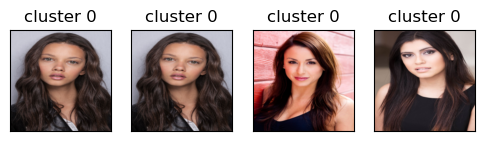

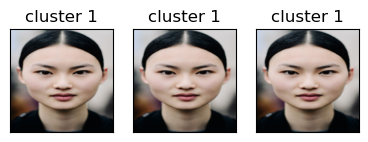

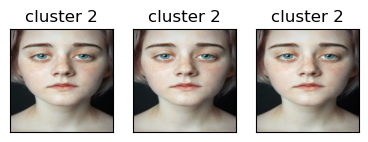

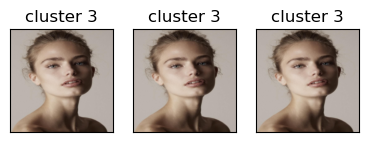

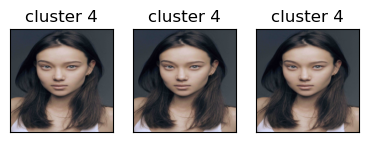

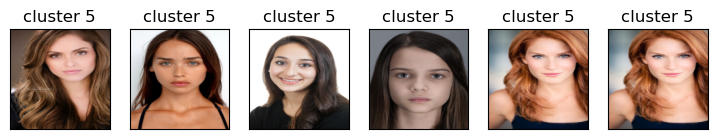

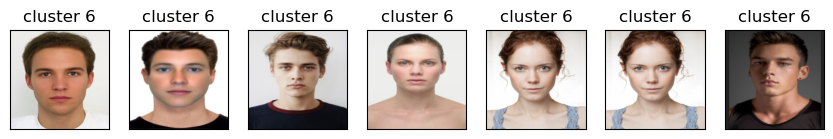

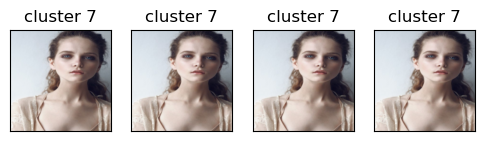

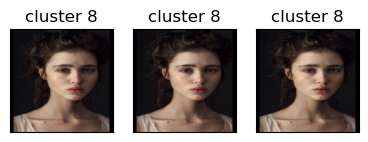

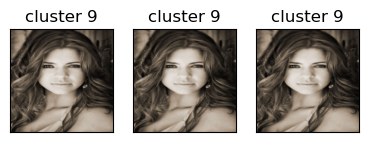

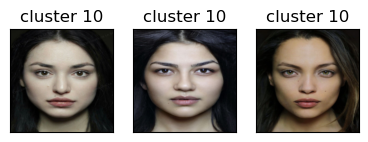

In [40]:
print_dbscan_clusters(Z_faces, faces_inputs, dbscan_labels)

Let's examine noise images identified by DBSCAN. 

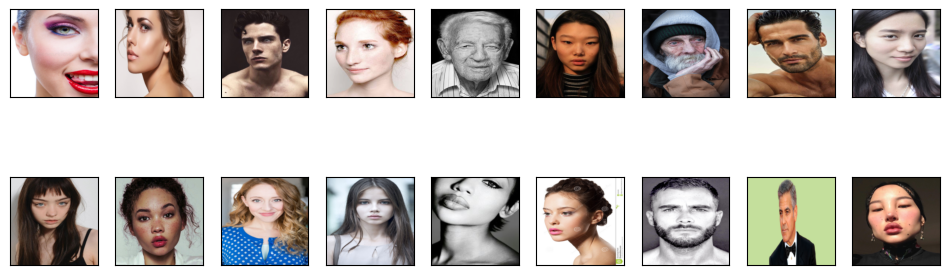

In [41]:
print_dbscan_noise_images(Z_faces, faces_inputs, dbscan_labels)

- We can guess why these images are noise images. There are odd angles, cropping, sun glasses, hands near faces etc. 

### Hierarchical clustering

In [42]:
set_seed(seed=42)

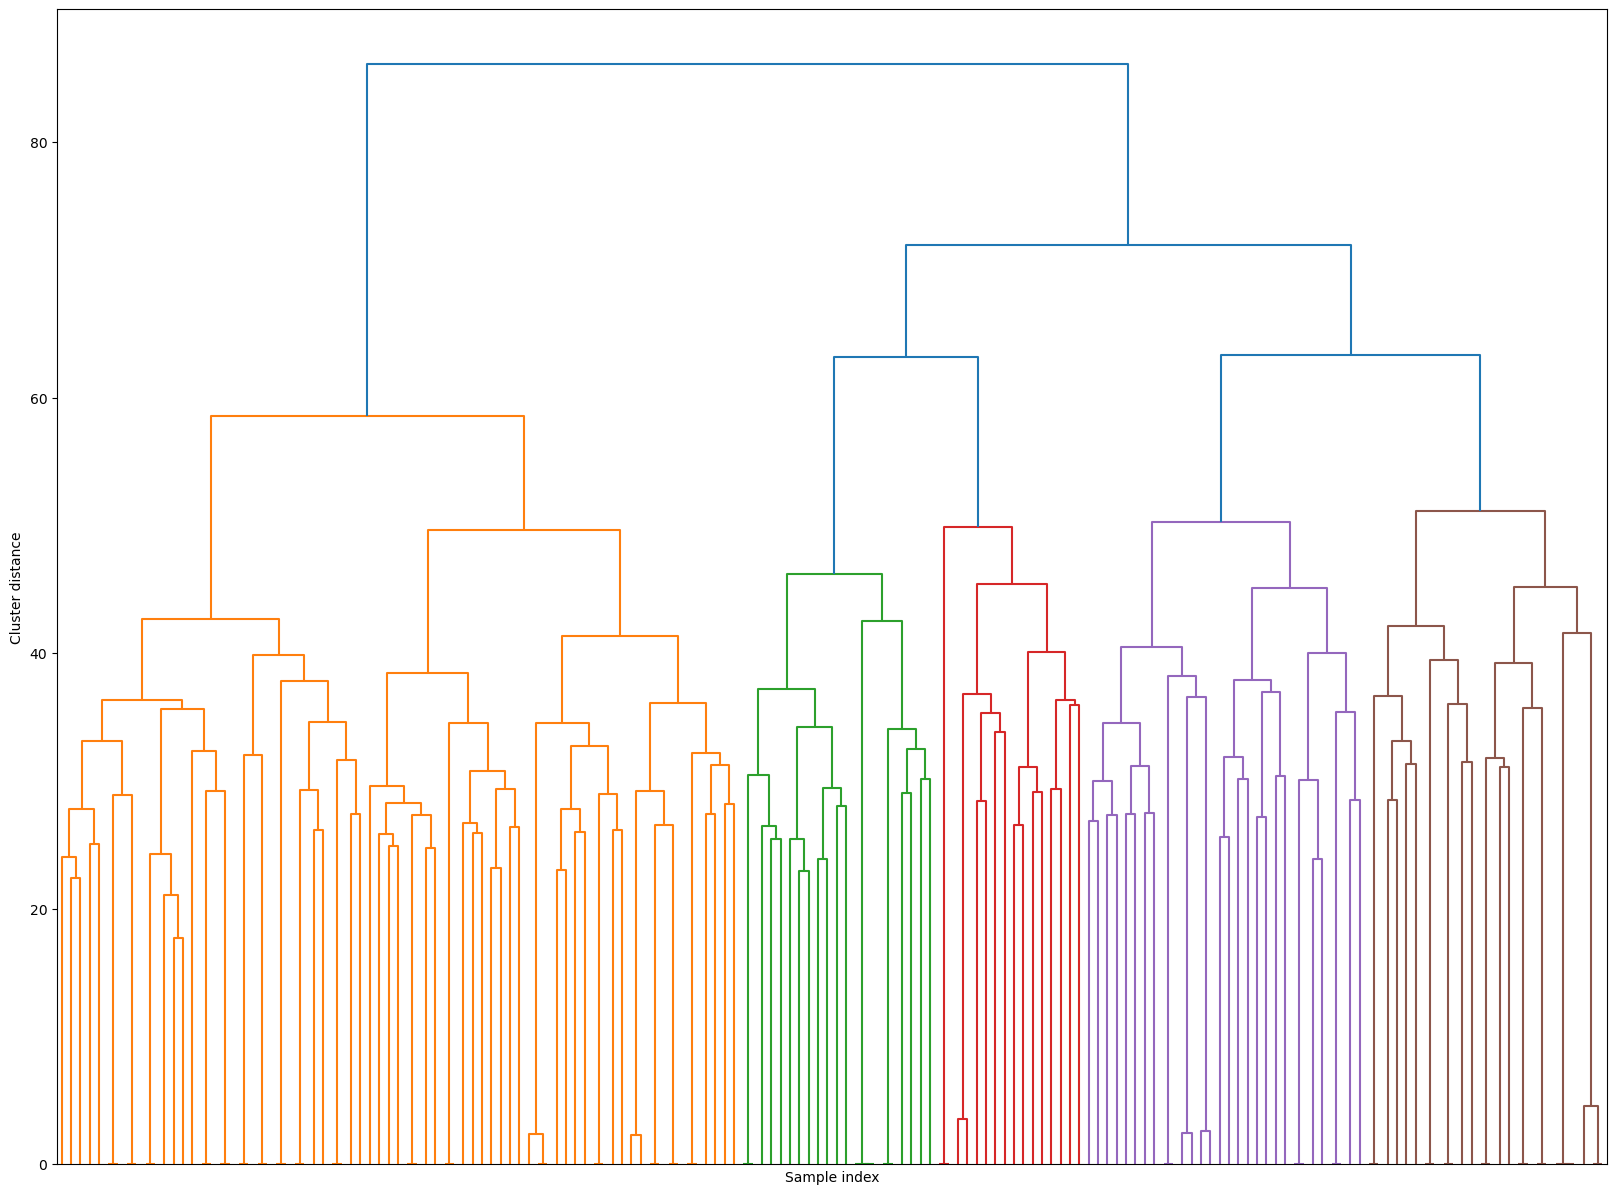

In [43]:
plt.figure(figsize=(20, 15))
Z_hrch = ward(Z_faces)
dendrogram(Z_hrch, p=7, truncate_mode="level", no_labels=True)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance");

In [44]:
cluster_labels = fcluster(Z_hrch, 30, criterion="maxclust")  # let's get flat clusters

/Users/kvarada/CS/2023-24/330/cpsc330-2023W1/lectures/code/plotting_functions_unsup.py:1490: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



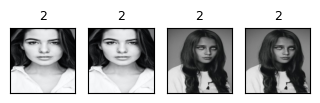

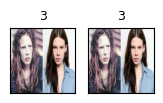

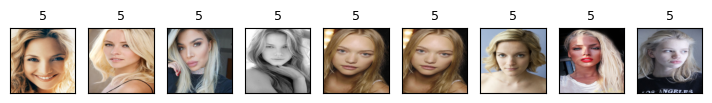

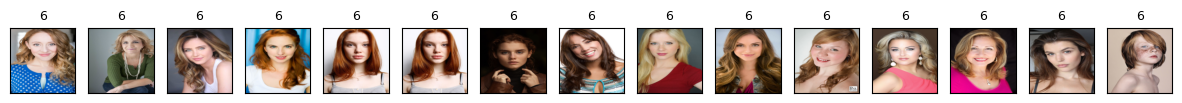

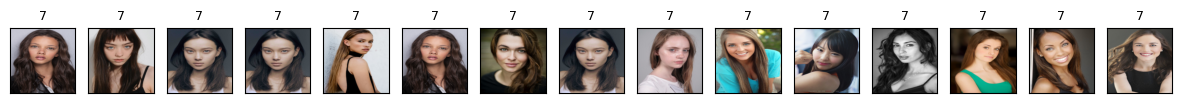

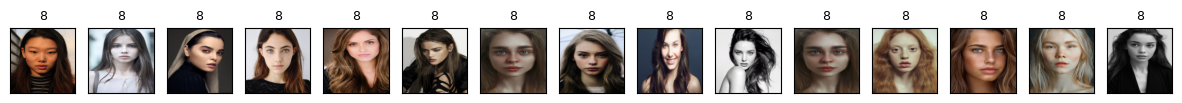

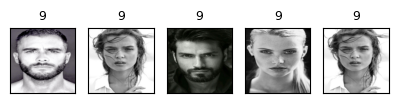

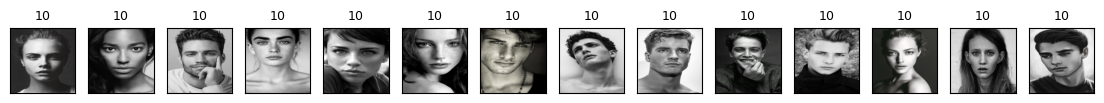

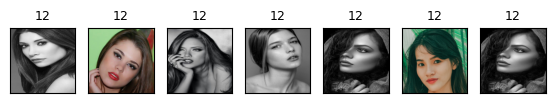

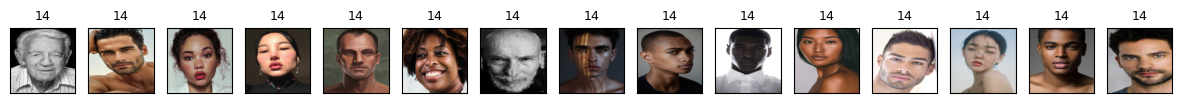

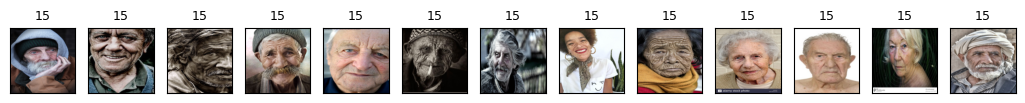

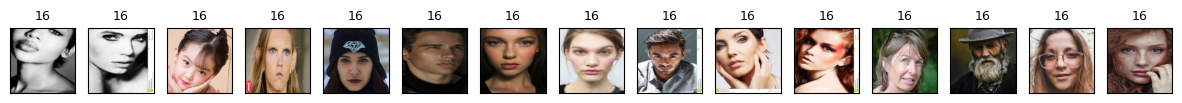

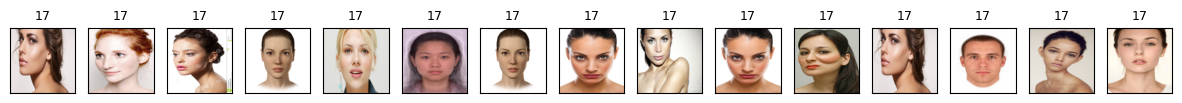

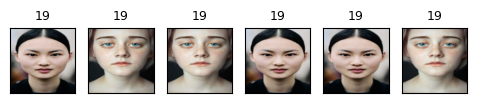

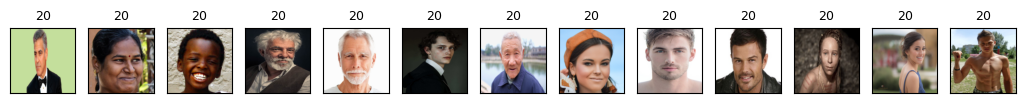

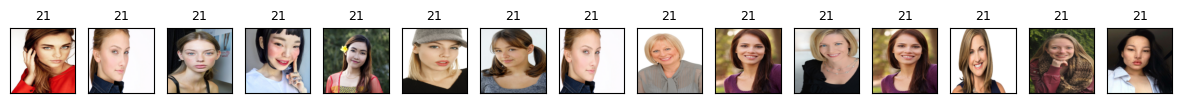

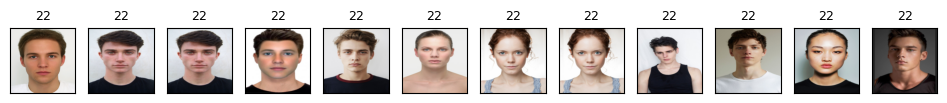

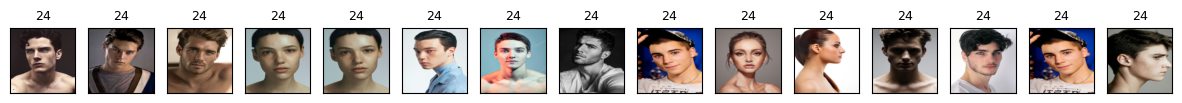

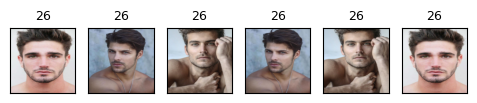

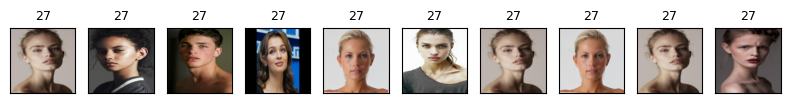

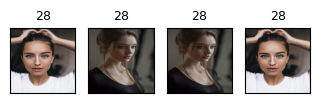

In [45]:
#hand_picked_clusters = np.arange(2, 30)
hand_picked_clusters = [2, 3, 5, 6,7, 8, 9, 10, 12, 14,15,16,17,19,20, 21,22, 24, 26, 27, 28]
print_hierarchical_clusters(
    faces_inputs, Z_faces, cluster_labels, hand_picked_clusters
)

- Some clusters correspond to people with distinct faces, age, facial expressions, hair colour and hair style, lighting and skin tone. 